In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score 

## 7. Preprocessing

In [6]:
Cleaned_Data_Churn = pd.read_csv("D:\\MyDesktop\\Machine_Learning\\SmartChurn\\Notebook\\Data\\cleaned_churn_data.xls")
Cleaned_Data_Churn.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin,monthly_charges_bin
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,"(0, 12]","(28, 38]"
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,One year,No,Mailed check,56.95,1889.50,No,"(24, 36]","(48, 58]"
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,"(0, 12]","(48, 58]"
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,"(36, 48]","(38, 48]"
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,"(0, 12]","(68, 78]"


In [88]:
# Drop non-predictive and created(Created for analysis purpose) columns.
Cleaned_Data_Churn.drop(columns=['customerID','tenure_bin','monthly_charges_bin'], inplace=True)

In [89]:
Cleaned_Data_Churn.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [90]:
# Encode target
le = LabelEncoder()
Cleaned_Data_Churn['Churn'] = le.fit_transform(Cleaned_Data_Churn['Churn'])  ## Yes=1, No=0

In [91]:
Cleaned_Data_Churn['Churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: Churn, dtype: int64

In [92]:
# Split features and target
X = Cleaned_Data_Churn.drop('Churn', axis=1)
y = Cleaned_Data_Churn['Churn']

In [93]:
# Column seperation for transformation
numeric_features = X.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

In [94]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [95]:
X_processed = preprocessor.fit_transform(X)

In [96]:
## KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_processed)

X_processed = np.hstack([X_processed, clusters.reshape(-1,1)]) # extra feature for classification
# This is required because np.hstack can only horizontally stack arrays with the same number of rows.
# np.hstack([X_processed, clusters.reshape(-1,1)]) - Horizontally stacks the cluster column to your preprocessed features.

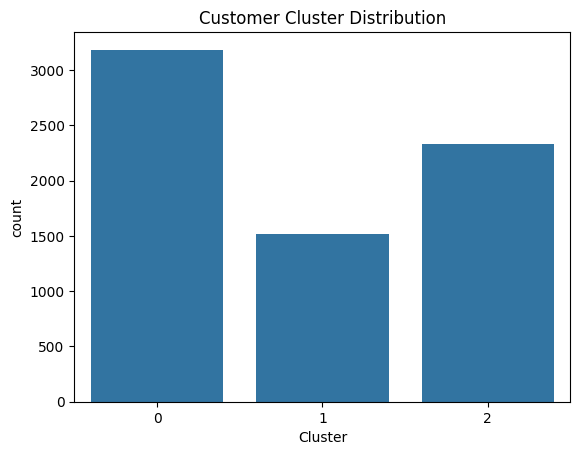

In [97]:
## Visaulizing Cluster columns 
X["Cluster"] = clusters # Add cluster column to the original dataset for analysis 
Cleaned_Data_Churn["Cluster"] = clusters   # add cluster labels to original dataset
sns.countplot(x="Cluster", data=Cleaned_Data_Churn)
plt.title("Customer Cluster Distribution")
plt.show()

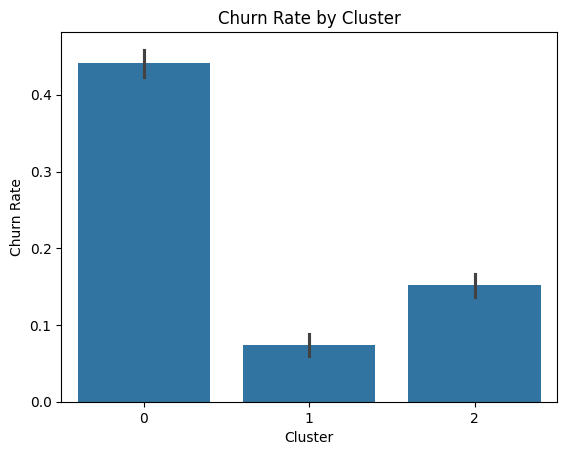

In [98]:
sns.barplot(x="Cluster", y="Churn", data=Cleaned_Data_Churn)
plt.title("Churn Rate by Cluster")
plt.ylabel("Churn Rate")
plt.xlabel("Cluster")
plt.show()

In [99]:
Cleaned_Data_Churn.groupby("Cluster")[["tenure","MonthlyCharges","TotalCharges"]].mean()

,tenure,MonthlyCharges,TotalCharges
Cluster,,,
0,15.324537,67.856111,1019.370342
1,30.667763,21.076283,665.220329
2,56.933018,89.153736,5066.714470


#### Observation:- 
#### Cluster 0 is the most at-risk cluster (less tenure but high monthly and total charges).
#### Cluster 1 is the most stable cluster (lowest churn).
#### Cluster 2 is somewhere in the middle (high tenure with most monthly and total charges)

In [100]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

In [101]:
num_pos = np.sum(y_train == 1)  # number of churners
num_neg = np.sum(y_train == 0)  # number of non-churners
scale_pos_weight = num_neg / num_pos
print("scale_pos_weight:", scale_pos_weight)

scale_pos_weight: 2.762541806020067


In [103]:
XGB = XGBClassifier(
    scale_pos_weight = 2.762541806020067,  # handles imbalance
    use_label_encoder = False, # avoids warnings with newer XGBoost versions.
    eval_metric = 'logloss',  # avoids warning
    random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 150],         # number of trees
    'max_depth': [3, 5, 7],                 # depth of each tree
    'learning_rate': [0.05, 0.1, 0.2],      # step size shrinkage
    'colsample_bytree': [0.7, 0.8, 1.0],    # fraction of features per tree
    'subsample': [0.7, 0.8, 1.0],           # fraction of rows per tree
    'min_child_weight': [1, 3, 5]           # minimum sum of instance weight in a child
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Multi-metric evaluation
scoring = {'F1': 'f1', 'ROC_AUC': 'roc_auc'}

grid_search = GridSearchCV(
    estimator = XGB,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring,
    refit = 'F1',      # Refit best model based on F1 score
    n_jobs = -1,
    verbose = 1
)

grid_search.fit(X_train, y_train)

# Best parameters and F1 score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# Evaluate on test data
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]  # probability for class 1

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'F1 Score': f1_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'ROC-AUC': roc_auc_score(y_test, y_prob)
}

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\chira\anaconda3\lib\site-packages\xgboost\training.py:183: UserWarning: [02:30:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.7}
Best F1 Score (CV): 0.6443023330416392
Accuracy: 0.7377
F1 Score: 0.6136
Precision: 0.5043
Recall: 0.7834
ROC-AUC: 0.8314


#### Observation:- 
#### F1 Score (0.6136) → Moderate, balances precision and recall reasonably.
#### Precision (0.5043) → About half of predicted churners are correct.
#### Recall (0.7834) → High, the model catches most actual churners (good for business).
#### Accuracy (0.7377) → Decent, but less meaningful due to class imbalance.
#### ROC-AUC (0.8314) → Strong ability to separate churners from non-churners.

In [108]:
import joblib
joblib.dump(best_model, "churn_model.joblib")

['churn_model.joblib']